<a href="https://colab.research.google.com/github/Jay9711/term_project_DM/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDClassifier

from sklearn.linear_model import LogisticRegression

import nltk
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB,CategoricalNB,BernoulliNB,GaussianNB,ComplementNB
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Flatten, Dense


In [5]:
df_comm = pd.read_csv('./Top_Posts_Comments.csv')
df_data = pd.read_csv('./Top_Posts.csv')


In [6]:
print(df_comm.head(5))
df_comm_edited = df_comm.dropna()

  post_id                                            comment
0  gh1dj9  Twitter thread: [https://twitter.com/cyrildiag...
1  gh1dj9                                       The future 🤯
2  gh1dj9  Simple yet very useful. Thank you for sharing ...
3  gh1dj9  Almost guaranteed, Apple will copy your idea i...
4  gh1dj9  Ohh the nightmare of making this into a stable...


In [7]:
nltk.download('stopwords')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = BeautifulSoup(text, "lxml").text
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text
df_comm_edited['comment'] = df_comm_edited['comment'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-7-14401dc1641b>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text
<ipython-input-7-14401dc1641b>:7: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text
<ipython-input-7-14401dc1641b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comm_edited['comment'] = df_comm_edited['

In [8]:
find = {}
for ind in df_data.index:
  find[df_data['post_id'][ind]]=df_data['subreddit'][ind]

labels = []
for ind in df_comm_edited.index:
  temp = df_comm['post_id'][ind]
  labels.append(find[temp])

In [9]:
df_comm_edited['labels'] = labels

<ipython-input-9-afbefb7825ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comm_edited['labels'] = labels


In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_comm_edited['comment'], df_comm_edited['labels'], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [11]:
print(type(X_train),type(y_train))

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [14]:
def naive_bayes():
  nb = Pipeline([('vect', CountVectorizer()),
               ('clf', MultinomialNB())])
  nb.fit(X_train, y_train)
  class_log_prior = nb.named_steps['clf'].class_log_prior_
  feature_log_prob = nb.named_steps['clf'].feature_log_prob_
  class_prior = np.exp(class_log_prior)
  feature_prob = np.exp(feature_log_prob)
  y_pred = nb.predict(X_val)
  return (accuracy_score(y_pred, y_val)),class_prior,feature_prob

In [15]:
print(naive_bayes())

(0.7098494353826851, array([0.42858957, 0.09101161, 0.48039882]), array([[5.71631455e-06, 1.73394875e-04, 6.35146061e-07, ...,
        6.35146061e-07, 6.35146061e-07, 6.35146061e-07],
       [5.29240540e-06, 1.50833554e-04, 2.64620270e-06, ...,
        5.29240540e-06, 5.29240540e-06, 5.29240540e-06],
       [7.19724777e-06, 2.08720185e-04, 1.79931194e-06, ...,
        5.99770648e-07, 5.99770648e-07, 5.99770648e-07]]))


In [26]:
def randomforest_classifier():
  temp_y_train = []
  temp_y_eval = []
  pred= []
  for i in y_train:
    if i =='MachineLearning':
        temp_y_train.append(1)
    elif i =='datascience':
        temp_y_train.append(2)
    elif i =='artificial':
        temp_y_train.append(3)
  for i in y_val:
    if i =='MachineLearning':
        temp_y_eval.append(1)
    elif i =='datascience':
        temp_y_eval.append(2)
    elif i =='artificial':
        temp_y_eval.append(3)
  vectorizer = CountVectorizer(min_df=1,max_features = 1000)
  X = vectorizer.fit_transform(X_train).toarray()
  clf = RandomForestClassifier()
  clf.fit(X, temp_y_train)
  pred.append(clf.predict(vectorizer.transform(X_val).toarray()))
  accuracy = 0
  k = 0
  for i in pred:
    for j in i:
      if temp_y_eval[k]==j:
        accuracy+=1
      k+=1
  return(accuracy/k)
  

In [ ]:
print(randomforest_classifier())

65.04301846208999


In [28]:
vectorizer = CountVectorizer(min_df=1,max_features = 1000)
X = vectorizer.fit_transform(X_train).toarray()
tfidf_transformer = TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(X)
print(tfidf_matrix)

  (1, 960)	0.25563043466166885
  (1, 956)	0.1794073703370791
  (1, 917)	0.2088913893774821
  (1, 886)	0.16613929184449117
  (1, 749)	0.18666567601705328
  (1, 678)	0.25826993543416393
  (1, 567)	0.1774467812307509
  (1, 530)	0.2528911620745609
  (1, 514)	0.27800247960598484
  (1, 484)	0.13607272849894403
  (1, 461)	0.2787368466180095
  (1, 459)	0.23398298260425326
  (1, 457)	0.16627823270221484
  (1, 412)	0.2704791962728253
  (1, 263)	0.21410890904570973
  (1, 241)	0.2851347179041767
  (1, 230)	0.19484799170385622
  (1, 199)	0.27919169949334866
  (1, 18)	0.24925972375407654
  (2, 385)	0.801929170592965
  (2, 380)	0.4220716085360414
  (2, 57)	0.42280629444212153
  (3, 992)	0.30052516246806393
  (3, 991)	0.27357374218453767
  (3, 949)	0.24401717304402282
  :	:
  (133894, 917)	0.09764052638808726
  (133894, 880)	0.07230646315798245
  (133894, 853)	0.11654880643237006
  (133894, 843)	0.09221203829479475
  (133894, 799)	0.12634552732805768
  (133894, 780)	0.10273898341272165
  (133894, 650)

In [ ]:
def neural_net():
  train_comments =X_train 
  train_labels = y_train 
  test_comments = X_val 
  test_labels = y_val 

  max_words = 1000
  tokenize = text.Tokenizer(num_words=max_words, char_level=False)
  tokenize.fit_on_texts(train_comments)

  x_tra = tokenize.texts_to_matrix(train_comments)
  x_tes = tokenize.texts_to_matrix(test_comments)

  encoder = LabelEncoder()
  encoder.fit(train_labels)
  y_tra = encoder.transform(train_labels)
  y_tes = encoder.transform(test_labels)

  num_classes = np.max(y_tra) + 1
  y_tra = utils.to_categorical(y_tra, num_classes)
  y_tes = utils.to_categorical(y_tes, num_classes)

  batch_size = 32
  epochs = 5

  model = Sequential()
  model.add(Dense(512, input_shape=(max_words,)))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
                
  history = model.fit(x_tra, y_tra,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_split=0.3)
  
  score = model.evaluate(x_tes, y_tes,
                       batch_size=batch_size, verbose=1)
  return score[1]


In [ ]:
print(neural_net())

Epoch 1/5
2929/2929 [==============================] - 40s 13ms/step - loss: 0.7511 - accuracy: 0.6484 - val_loss: 0.7238 - val_accuracy: 0.6607
Epoch 2/5
2929/2929 [==============================] - 38s 13ms/step - loss: 0.7027 - accuracy: 0.6751 - val_loss: 0.7211 - val_accuracy: 0.6627
Epoch 3/5
2929/2929 [==============================] - 38s 13ms/step - loss: 0.6642 - accuracy: 0.6947 - val_loss: 0.7270 - val_accuracy: 0.6650
Epoch 4/5
2929/2929 [==============================] - 36s 12ms/step - loss: 0.6168 - accuracy: 0.7196 - val_loss: 0.7358 - val_accuracy: 0.6602
Epoch 5/5
1395/1395 [==============================] - 6s 5ms/step - loss: 0.7642 - accuracy: 0.6586
0.658585786819458


In [23]:
def svm():
  sgd = Pipeline([('vect', CountVectorizer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
  sgd.fit(X_train, y_train)

  y_pred = sgd.predict(X_test)
  return accuracy_score (y_pred,y_test)


In [24]:
print(svm())

0.692081914321563


In [ ]:
def logistic_regression():
  logreg = Pipeline([('vect', CountVectorizer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
  logreg.fit(X_train, y_train)


  y_pred = logreg.predict(X_test)

  return (accuracy_score(y_pred, y_test))

In [ ]:
print(logistic_regression())

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6888555296648144


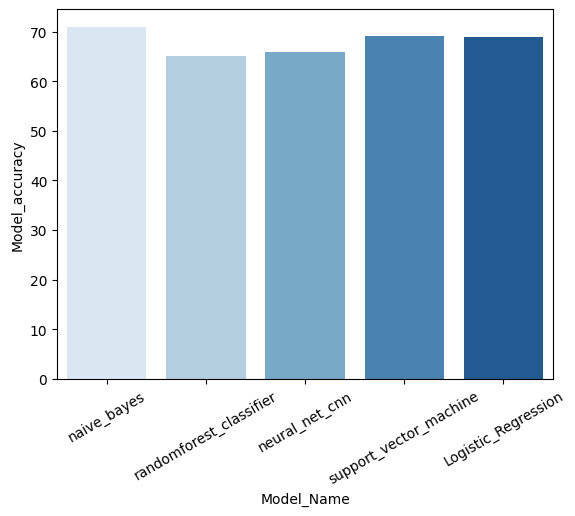

In [4]:
mode = ['naive_bayes','randomforest_classifier','neural_net_cnn','support_vector_machine','Logistic_Regression']
mode_accuracy= [70.98,65.04,65.85,69.20,68.88]
df = pd.DataFrame(mode, columns=['Model_Name'])
df['Model_accuracy']=mode_accuracy
sns.barplot(data=df,x='Model_Name',y='Model_accuracy',palette = "Blues")
plt.xticks(rotation = 30)
plt.show()

# Contribution : Implement each Algorithms with TFIDF Transformer

In [21]:
def naive_bayes_tfidf():
  nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
  nb.fit(X_train, y_train)
  y_pred = nb.predict(X_val)
  return accuracy_score(y_pred, y_val)

In [22]:
mode.append('naive_bayes_tfidf')
mode_accuracy.append(naive_bayes_tfidf())

In [24]:
def randomforest_classifier_tfidf():
  temp_y_train = []
  temp_y_eval = []
  pred= []
  for i in y_train:
    if i =='MachineLearning':
        temp_y_train.append(1)
    elif i =='datascience':
        temp_y_train.append(2)
    elif i =='artificial':
        temp_y_train.append(3)
  for i in y_val:
    if i =='MachineLearning':
        temp_y_eval.append(1)
    elif i =='datascience':
        temp_y_eval.append(2)
    elif i =='artificial':
        temp_y_eval.append(3)
  clf = Pipeline([
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier()),
              ])
  vectorizer = CountVectorizer(min_df=1,max_features = 1000)
  X = vectorizer.fit_transform(X_train).toarray()
  clf.fit(X, temp_y_train)
  pred.append(clf.predict(vectorizer.transform(X_val).toarray()))
  accuracy = 0
  k = 0
  for i in pred:
    for j in i:
      if temp_y_eval[k]==j:
        accuracy+=1
      k+=1
  return(accuracy/k)

In [33]:
mode_accuracy.append(randomforest_classifier_tfidf())
mode.append('Random_Forest_tfidf')

In [34]:
print(mode)
print(mode_accuracy)

['naive_bayes', 'randomforest_classifier', 'neural_net_cnn', 'support_vector_machine', 'Logistic_Regression', 'naive_bayes_tfidf', 'Random_Forest_tfidf']
[70.98, 65.04, 65.85, 69.2, 68.88, 0.7027245025990321, 0.660400609428213]


In [71]:
def neural_net_tfidf():
  train_comments =X_train 
  train_labels = y_train 
  test_comments = X_val 
  test_labels = y_val 

  # max_words = 1000
  # tokenize = text.Tokenizer(num_words=max_words, char_level=False)
  # tokenize.fit_on_texts(train_comments)

  # x_tra = tokenize.texts_to_matrix(train_comments)
  # x_tes = tokenize.texts_to_matrix(test_comments)

  # print(type(x_tra))

  tfidf = TfidfVectorizer(binary=True,max_features=1000)
  x_tra = tfidf.fit_transform(train_comments).astype('float16')
  x_tes = tfidf.transform(test_comments).astype('float16')

  print(type(x_tra))
  encoder = LabelEncoder()
  encoder.fit(train_labels)
  y_tra = encoder.transform(train_labels)
  y_tes = encoder.transform(test_labels)

  num_classes = np.max(y_tra) + 1
  y_tra = utils.to_categorical(y_tra, num_classes)
  y_tes = utils.to_categorical(y_tes, num_classes)

  batch_size = 32
  epochs = 5

  model = Sequential()
  model.add(Dense(512, input_shape=(1000,)))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
                
  history = model.fit(x_tra, y_tra,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1)
  
  score = model.evaluate(x_tes, y_tes,
                       batch_size=batch_size, verbose=1)
  return score[1]


In [72]:
mode_accuracy.append(neural_net_tfidf())
mode.append('neural_net_tfidf')

<class 'scipy.sparse._csr.csr_matrix'>
Epoch 1/5
4185/4185 [==============================] - 45s 11ms/step - loss: 0.7475 - accuracy: 0.6496
Epoch 2/5
4185/4185 [==============================] - 56s 13ms/step - loss: 0.7180 - accuracy: 0.6663
Epoch 3/5
4185/4185 [==============================] - 48s 11ms/step - loss: 0.6988 - accuracy: 0.6785
Epoch 4/5
4185/4185 [==============================] - 63s 15ms/step - loss: 0.6757 - accuracy: 0.6916
Epoch 5/5
1395/1395 [==============================] - 5s 3ms/step - loss: 0.7299 - accuracy: 0.6622


In [73]:
def svm_tfidf():
  sgd = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
  sgd.fit(X_train, y_train)

  y_pred = sgd.predict(X_test)
  return accuracy_score (y_pred,y_test)

In [74]:
mode_accuracy.append(svm_tfidf())
mode.append('svm_tfidf')

In [77]:
def logistic_regression_tfidf():
  logreg = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
  logreg.fit(X_train, y_train)


  y_pred = logreg.predict(X_test)

  return (accuracy_score(y_pred, y_test))

In [78]:
mode_accuracy.append(logistic_regression_tfidf())
mode.append('logistic_regression_tfidf')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [181]:
mode = ['naive_bayes', 'randomforest_classifier', 'neural_net_cnn', 'support_vector_machine', 'Logistic_Regression', 'naive_bayes_tfidf', 'Random_Forest_tfidf', 'neural_net_tfidf', 'svm_tfidf', 'logistic_regression_tfidf']
mode_accuracy=[70.98, 65.04, 65.85, 69.2, 68.88, 0.7027245025990321, 0.660400609428213, 0.6622154712677002, 0.6648592937802473, 0.7002823086574655]

print(mode)
print(mode_accuracy)


['naive_bayes', 'randomforest_classifier', 'neural_net_cnn', 'support_vector_machine', 'Logistic_Regression', 'naive_bayes_tfidf', 'Random_Forest_tfidf', 'neural_net_tfidf', 'svm_tfidf', 'logistic_regression_tfidf']
[70.98, 65.04, 65.85, 69.2, 68.88, 0.7027245025990321, 0.660400609428213, 0.6622154712677002, 0.6648592937802473, 0.7002823086574655]


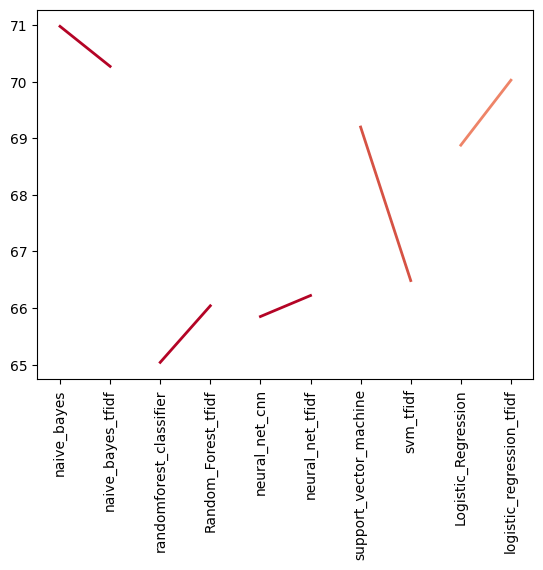

In [183]:
colo=1.2
for i in range(0,5):
  x = [mode[i],mode[i+5]]
  y = np.array([mode_accuracy[i],mode_accuracy[i+5]*100])
  plt.plot(x, y,color=plt.cm.coolwarm(colo),linewidth=2)
  colo-=0.1  

plt.xticks(rotation = 90)
plt.show()

# HyperParameter Tuning

In [123]:
def naive_bayes_HP(a):
  
  nb = Pipeline([('vect', CountVectorizer()), 
               ('clf', MultinomialNB(alpha=a,force_alpha=True))])
  nb.fit(X_train, y_train)
  y_pred = nb.predict(X_val)
  # proba = nb.predict_proba(X_train)
  # print(proba)
  return accuracy_score(y_pred, y_val)


In [124]:
def naive_bayes_HP_tfifd(a):
  
  nb = Pipeline([('vect', CountVectorizer()), 
                 ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB(alpha=a,force_alpha=True))])
  nb.fit(X_train, y_train)
  y_pred = nb.predict(X_val)
  # proba = nb.predict_proba(X_train)
  # print(proba)
  return accuracy_score(y_pred, y_val)

In [149]:
hp_tuning_bag_of_words=[]
hp_tuning_tfidf=[]
alph= []
for i in range(0,12):
  hp_tuning_bag_of_words.append(naive_bayes_HP(i/10)*100)
  hp_tuning_tfidf.append(naive_bayes_HP_tfifd(i/10)*100)
  alph.append(i/10)

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(


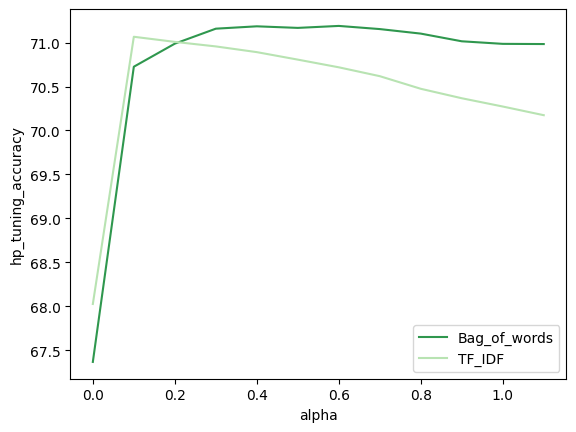

In [152]:
df = pd.DataFrame()
df['hp_tuning_accuracy']=hp_tuning_bag_of_words
df['hp_tuning_accuracy_tfidf']=hp_tuning_tfidf
df['alpha']=alph
cmap = sns.color_palette("Greens", as_cmap=True)
sns.lineplot(data=df,x='alpha',y='hp_tuning_accuracy',color=cmap(.7),label='Bag_of_words')
sns.lineplot(data=df,x='alpha',y='hp_tuning_accuracy_tfidf',color=cmap(.3),label='TF_IDF')
plt.show()

In [135]:
def randomforest_classifier_hp_tuning(b,c,d):
  temp_y_train = []
  temp_y_eval = []
  pred= []
  for i in y_train:
    if i =='MachineLearning':
        temp_y_train.append(1)
    elif i =='datascience':
        temp_y_train.append(2)
    elif i =='artificial':
        temp_y_train.append(3)
  for i in y_val:
    if i =='MachineLearning':
        temp_y_eval.append(1)
    elif i =='datascience':
        temp_y_eval.append(2)
    elif i =='artificial':
        temp_y_eval.append(3)
  vectorizer = CountVectorizer(min_df=1,max_features = 1000)
  X = vectorizer.fit_transform(X_train).toarray()
  clf = RandomForestClassifier(max_depth=b,n_estimators=c,min_samples_split=d)
  clf.fit(X, temp_y_train)
  pred.append(clf.predict(vectorizer.transform(X_val).toarray()))
  accuracy = 0
  k = 0
  for i in pred:
    for j in i:
      if temp_y_eval[k]==j:
        accuracy+=1
      k+=1
  return(accuracy/k)
  

In [139]:
hp_tuning=[0]
estimator = [20,30,40,110,150]
for i in range(50,100,10):
  b = random.choice(estimator)
  c = random.randint(0, i)
  temp = randomforest_classifier_hp_tuning(i,b,c)*100
  if temp>max(hp_tuning):
    best_estimator=[i,b,c]
  hp_tuning.append(temp)
print(hp_tuning)

[0, 64.20281412439506, 64.79207743323177, 65.43735436458147, 65.439594909482, 65.62556013622512]


In [140]:
print(best_estimator)

[90, 110, 13]


In [145]:
def randomforest_classifier_hp_tuning_tfidf(c,d):
  temp_y_train = []
  temp_y_eval = []
  pred= []
  for i in y_train:
    if i =='MachineLearning':
        temp_y_train.append(1)
    elif i =='datascience':
        temp_y_train.append(2)
    elif i =='artificial':
        temp_y_train.append(3)
  for i in y_val:
    if i =='MachineLearning':
        temp_y_eval.append(1)
    elif i =='datascience':
        temp_y_eval.append(2)
    elif i =='artificial':
        temp_y_eval.append(3)
  clf = Pipeline([
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(n_estimators=c,min_samples_split=d)),
              ])
  vectorizer = CountVectorizer(min_df=1,max_features = 1000)
  X = vectorizer.fit_transform(X_train).toarray()
  clf.fit(X, temp_y_train)
  pred.append(clf.predict(vectorizer.transform(X_val).toarray()))
  accuracy = 0
  k = 0
  for i in pred:
    for j in i:
      if temp_y_eval[k]==j:
        accuracy+=1
      k+=1
  return(accuracy/k)

In [146]:
hp_tuning_tfidf=[0]
estimator = [20,50,70,110,150,130]
for i in range(50,100,10):
  b = random.choice(estimator)
  c = random.randint(0, 10)
  temp = randomforest_classifier_hp_tuning_tfidf(b,c)*100
  if temp>max(hp_tuning_tfidf):
    best_estimator=[i,b,c]
  hp_tuning_tfidf.append(temp)
print(hp_tuning_tfidf)

[0, 65.36341638286432, 66.04678257752286, 66.06022584692597, 65.86977953038179, 66.01093385911454]


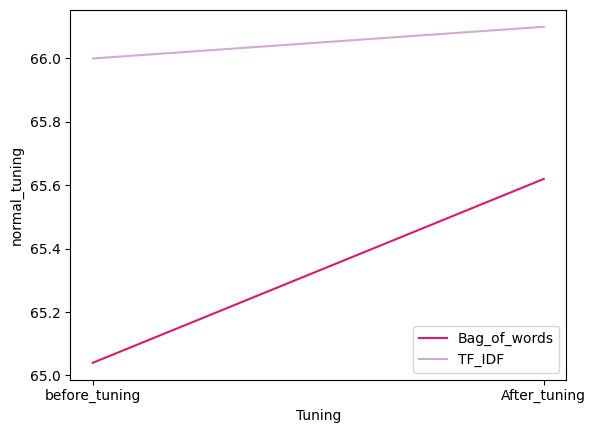

In [159]:
normal_tuning = [65.04,65.62]
TFIDF_tuning = [66.0,66.1]
df = pd.DataFrame()
df['normal_tuning']=normal_tuning
df['TFIDF_tuning']=TFIDF_tuning
df['Tuning']=['before_tuning','After_tuning']
cmap = sns.color_palette("PuRd", as_cmap=True)
sns.lineplot(data=df,x='Tuning',y='normal_tuning',color=cmap(.7),label='Bag_of_words')
sns.lineplot(data=df,x='Tuning',y='TFIDF_tuning',color=cmap(.3),label='TF_IDF')
plt.show()

In [160]:
def svm_hp_tuning(a,b):
  sgd = Pipeline([('vect', CountVectorizer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=a, random_state=42, max_iter=b, tol=None)),
               ])
  sgd.fit(X_train, y_train)

  y_pred = sgd.predict(X_test)
  return accuracy_score (y_pred,y_test)

In [161]:
def svm_tfidf_hp_tuning(a,b):
  sgd = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=a, random_state=42, max_iter=b, tol=None)),
               ])
  sgd.fit(X_train, y_train)

  y_pred = sgd.predict(X_test)
  return accuracy_score (y_pred,y_test)

In [165]:
hp_tuning_bag_of_words=[]
hp_tuning_tfidf=[]
alph= []
a_list = [0.001, 0.01, 0.1, 1, 10, 100]
for i in range(1,12):
  a = random.choice(a_list)
  hp_tuning_bag_of_words.append(svm_hp_tuning(a,i))
  hp_tuning_tfidf.append(svm_tfidf_hp_tuning(a,i))
  alph.append(f'alpha = {a} & Iterations = {i}')



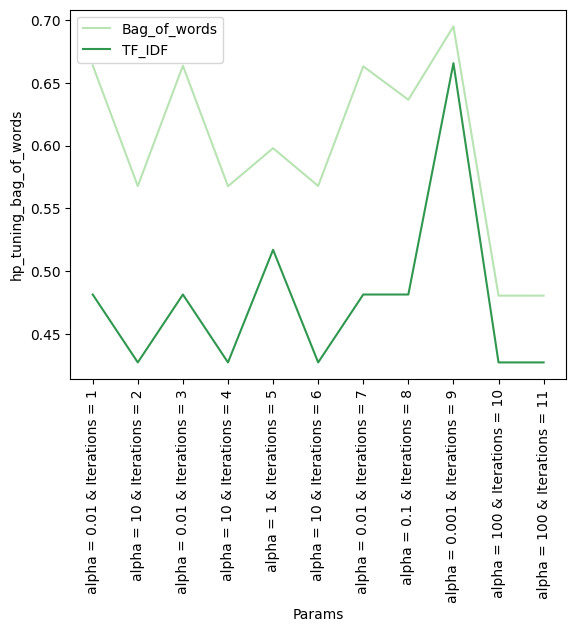

In [169]:
df = pd.DataFrame()
df['hp_tuning_bag_of_words']=hp_tuning_bag_of_words
df['hp_tuning_tfidf']=hp_tuning_tfidf
df['Params']=alph
cmap = sns.color_palette("Greens_r", as_cmap=True)
sns.lineplot(data=df,x='Params',y='hp_tuning_bag_of_words',color=cmap(.7),label='Bag_of_words')
sns.lineplot(data=df,x='Params',y='hp_tuning_tfidf',color=cmap(.3),label='TF_IDF')
plt.xticks(rotation = 90)
plt.show()

In [172]:
def logistic_regression_HP_tuning(a,b,c):
  logreg = Pipeline([('vect', CountVectorizer()),
                ('clf', LogisticRegression(n_jobs=1, C=b,max_iter=c,penalty=a)),
               ])
  logreg.fit(X_train, y_train)


  y_pred = logreg.predict(X_test)

  return (accuracy_score(y_pred, y_test))

In [173]:
def logistic_regression_tfidf_HP_tuning(a,b,c):
  logreg = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=b,max_iter=c,penalty=a)),
               ])
  logreg.fit(X_train, y_train)


  y_pred = logreg.predict(X_test)

  return (accuracy_score(y_pred, y_test))

In [186]:
a=['l2']
b=[0.001, 0.01, 0.1, 1, 10, 100]
c = [100,75,50,125,150]
hp_tuning_bag_of_words=[]
hp_tuning_tfidf=[]
alph= []
for i in range(5):
  temp = random.choice(a)
  temp2 = random.choice(b)
  temp3 = random.choice(c)
  hp_tuning_bag_of_words.append(logistic_regression_HP_tuning(temp,temp2,temp3))
  hp_tuning_tfidf.append(logistic_regression_tfidf_HP_tuning(temp,temp2,temp3))
  alph.append(f'learning_rate = {temp2} & Penalty = {temp}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

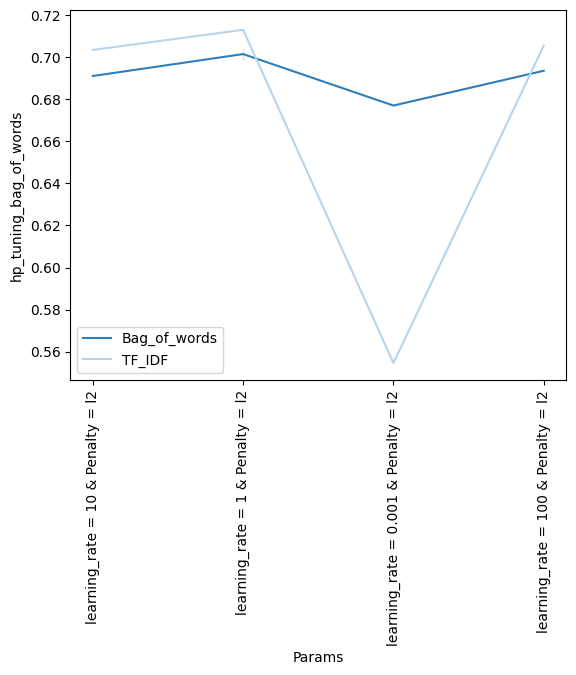

In [187]:
df = pd.DataFrame()
df['hp_tuning_bag_of_words']=hp_tuning_bag_of_words
df['hp_tuning_tfidf']=hp_tuning_tfidf
df['Params']=alph
cmap = sns.color_palette("Blues", as_cmap=True)
sns.lineplot(data=df,x='Params',y='hp_tuning_bag_of_words',color=cmap(.7),label='Bag_of_words')
sns.lineplot(data=df,x='Params',y='hp_tuning_tfidf',color=cmap(.3),label='TF_IDF')
plt.xticks(rotation = 90)
plt.show()